# Conditional Variational Autoencoder

![VAE](notebook_images/cvae.jpg)

When using a VAE or a vanilla autoencoder we have no control of what is generated when providing a latent space element to the decoder. Conditional VAEs fix this issue by adding a condition during training. This condition can be the class label, or a set of features. 

By conditioning the output, exploring the latent space provides meaningful variation within based on the condition.

Although the original paper proposes using the condition both at the encoder and the decoder, in practice with some examples it is enough to add it only as part of the latent space.

**Original paper:**

Learning Structured Output Representation using Deep Conditional Generative Models, Kihyuk Sohn, Xinchen Yan, Honglak Lee - Auto-Encoding Variational Bayes - https://proceedings.neurips.cc/paper_files/paper/2015/file/8d55a249e6baa5c06772297520da2051-Paper.pdf

**Further reading:**

Understanding Conditional Variational Autoencoders - https://theaiacademy.blogspot.com/2020/05/understanding-conditional-variational.html





In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import torchinfo

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.patches import Rectangle

import numpy as np
import time

import os
import pathlib
from PIL import Image
import skimage

# importing a module with utilities for displaying stats and data
import sys
sys.path.insert(1, '../util')
import vcpi_util

In [2]:
print(torch.__version__)

2.2.1+cu118


In [17]:
from matplotlib import colors

def plot_scatter(x,y,targets):
    cmap = colors.ListedColormap(['black', 'darkred', 'darkblue', 
                                  'darkgreen', 'yellow', 'brown', 
                                  'purple', 'lightgreen', 'red', 'lightblue'])
    bounds=[0, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5,8.5,9.5]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    plt.figure(figsize=(12,10))
    plt.scatter(x, y, c = targets, cmap=cmap, s = 1, norm=norm)
    plt.colorbar()

    plt.show()


def show_preds(set1, set2, count):
  
  columns = 4
  rows = int(count*2 / columns) + 1  
  plt.figure(figsize=(count, 2 * rows))
  
  for n in range(count):
      ax = plt.subplot(rows, columns, n*2+1)
      plt.title("original")
      plt.imshow(np.transpose(set1[n].numpy(), (1,2,0)), cmap=plt.cm.gray)
      plt.axis('off')
      ax = plt.subplot(rows, columns, n*2+2)
      plt.title("reconstruction")
      plt.imshow(np.transpose(set2[n].cpu().detach().numpy(), (1,2,0)), cmap=plt.cm.gray)
      plt.axis('off')      

## Configuration

In [3]:
HEIGHT = 28
WIDTH = 28
NUM_CHANNELS = 1
BATCH_SIZE = 32
LATENT_SPACE_DIM = 2

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)


cuda:0


### Load and prepare MNIST dataset

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor()]) #, transforms.RandomHorizontalFlip(1.0)])

train_set = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True)

test_set = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False)

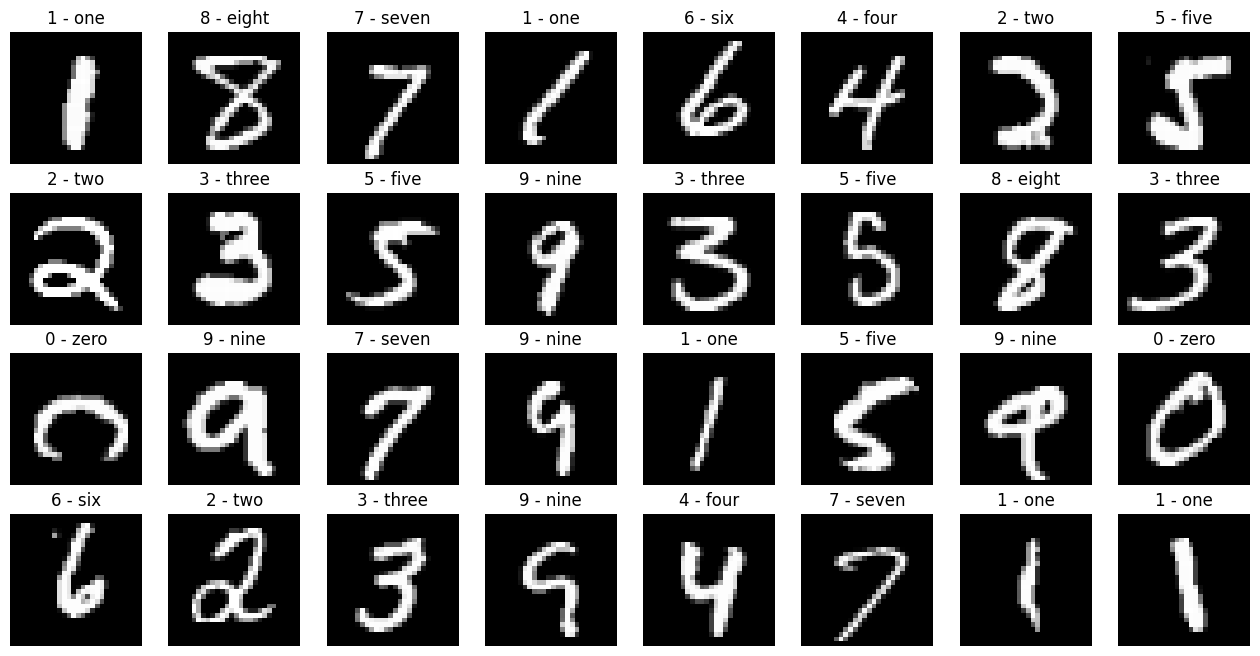

<Figure size 640x480 with 0 Axes>

In [5]:
images, targets = next(iter(train_loader))

vcpi_util.show_images(4,8, images, targets, train_set.classes) 

## Architecture

In [6]:
class Encoder(torch.nn.Module):

    def __init__(self, latent_space_dim):

        super().__init__()

        # encoder layers
        self.econv1 = torch.nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size= 3, stride = 2)
        self.erelu1 = torch.nn.ReLU()
        self.ebn1 = torch.nn.BatchNorm2d(32)

        self.econv2 = torch.nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size= 3, stride = 2)
        self.erelu2 = torch.nn.ReLU()
        self.ebn2 = torch.nn.BatchNorm2d(64)

        self.efc1_mean = torch.nn.Linear(3136, latent_space_dim)
        self.efc1_log_var = torch.nn.Linear(3136, latent_space_dim)

    def forward(self, x):

        x = torch.nn.functional.pad(x, (0,1,0,1)) # pad left, right, top, bottom
        x = self.econv1(x)
        x = self.ebn1(x)
        x = self.erelu1(x)

        x = torch.nn.functional.pad(x, (0,1,0,1)) # pad left, right, top, bottom
        x = self.econv2(x)
        x = self.ebn2(x)
        x = self.erelu2(x)

        x = torch.flatten(x,1)
        mean = self.efc1_mean(x)
        log_var = self.efc1_log_var(x)

        return mean, log_var


In [7]:
class Decoder(torch.nn.Module):

    def __init__(self, latent_space_dim, condition_dim):
        
        super().__init__()

        self.dfc1 = torch.nn.Linear(latent_space_dim + condition_dim, 3136)
        
        self.dconvT1 = torch.nn.ConvTranspose2d(64, 32, 3, 2, padding = 1, output_padding=1)
        self.drelu1 = torch.nn.ReLU()
        self.dbn1 = torch.nn.BatchNorm2d(32)

        self.dconvT2 = torch.nn.ConvTranspose2d(32, 1,3,2, padding = 1, output_padding = 1)
        self.dsig = torch.nn.Sigmoid()


    def forward(self, x, condition):


        x = self.dfc1(torch.cat([x,condition],1))
        x = x.reshape(-1, 64, 7, 7)
        x = self.dconvT1(x)
        x = self.dbn1(x)
        x = self.drelu1(x)

        x = self.dconvT2(x)
        x = self.dsig(x)

        return x        

In [8]:
class CVAE(torch.nn.Module):

    def __init__(self, encoder, decoder):

        super().__init__()

        self.encoder = encoder
        self.decoder = decoder

    def reparametrization(self, mean, var):

        epsilon = torch.randn_like(mean).to(device)    
        z = mean + var * epsilon  
        return z  

    def forward(self, x,condition):

        mean, log_var = self.encoder(x)
        var = torch.exp(0.5 * log_var)
        z = self.reparametrization(mean, var)
        output = self.decoder(z, condition)

        return output, mean, log_var

In [10]:
encoder = Encoder(LATENT_SPACE_DIM)
decoder = Decoder(LATENT_SPACE_DIM, 10)

model = CVAE(encoder=encoder, decoder=decoder).to(device)
model.to(device)

torchinfo.summary(model, input_size=[(BATCH_SIZE, 1, 28, 28),(BATCH_SIZE, 10)], col_names=["kernel_size", "input_size", "output_size", "num_params", "mult_adds"])



Layer (type:depth-idx)                   Kernel Shape              Input Shape               Output Shape              Param #                   Mult-Adds
CVAE                                     --                        [32, 1, 28, 28]           [32, 1, 28, 28]           --                        --
├─Encoder: 1-1                           --                        [32, 1, 28, 28]           [32, 2]                   --                        --
│    └─Conv2d: 2-1                       [3, 3]                    [32, 1, 29, 29]           [32, 32, 14, 14]          320                       2,007,040
│    └─BatchNorm2d: 2-2                  --                        [32, 32, 14, 14]          [32, 32, 14, 14]          64                        2,048
│    └─ReLU: 2-3                         --                        [32, 32, 14, 14]          [32, 32, 14, 14]          --                        --
│    └─Conv2d: 2-4                       [3, 3]                    [32, 32, 15, 15]          [3

In [11]:
BCE_loss = torch.nn.BCELoss(reduction = 'sum')

def loss_function(x, output, mean, log_var):
    reproduction_loss = BCE_loss(output, x)
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD


optimizer = torch.optim.Adam(model.parameters())

In [12]:
EPOCHS = 10

def one_hot(labels, class_size):
    targets = torch.zeros(labels.size(0), class_size)
    for i, label in enumerate(labels):
        targets[i, label] = 1
    return targets.to(device)

print("Start training CVAE...")
model.train()

for epoch in range(EPOCHS):
    overall_loss = 0
    for batch_idx, (x, y) in enumerate(train_loader):

        x = x.to(device)
        
        y = torch.nn.functional.one_hot(y, 10).to(device)

        optimizer.zero_grad()

        output, mean, log_var = model(x,y)
        loss = loss_function(x, output, mean, log_var)
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss / (batch_idx*BATCH_SIZE))
    
print("Finish!!")

Start training CVAE...
	Epoch 1 complete! 	Average Loss:  165.03516124533996
	Epoch 2 complete! 	Average Loss:  138.98294923959446
	Epoch 3 complete! 	Average Loss:  137.41452788085286
	Epoch 4 complete! 	Average Loss:  136.64774483728561
	Epoch 5 complete! 	Average Loss:  136.0915057122262
	Epoch 6 complete! 	Average Loss:  135.6552928733215
	Epoch 7 complete! 	Average Loss:  135.37676133570065
	Epoch 8 complete! 	Average Loss:  135.12489668155047
	Epoch 9 complete! 	Average Loss:  134.93878351738766
	Epoch 10 complete! 	Average Loss:  134.76959181289917
Finish!!


In [13]:
torch.save({
                'epoch': epoch,
                'model':model.state_dict(),
                'optimizer': optimizer.state_dict()
                },
                f'cvae_{LATENT_SPACE_DIM}_best.pt')

In [15]:
LATENT_SPACE_DIM = 2
reload = torch.load(f'cvae_{LATENT_SPACE_DIM}_best.pt')
print(reload['epoch'])
model = CVAE(Encoder(LATENT_SPACE_DIM), Decoder(LATENT_SPACE_DIM, 10))
model.to(device)
model.load_state_dict(reload['model'])

9


<All keys matched successfully>

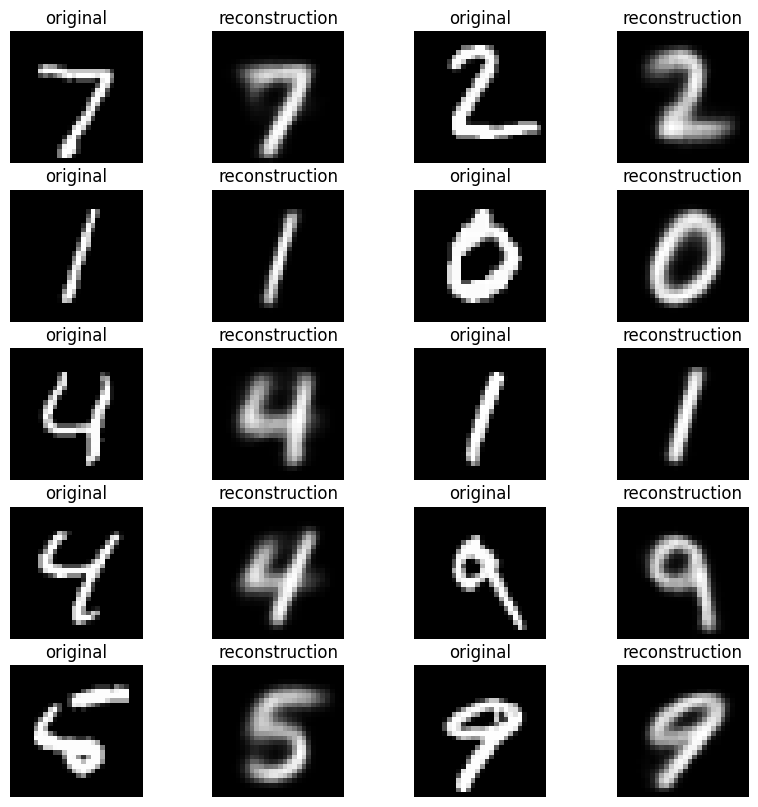

In [18]:
i, t = next(iter(test_loader))
recon,_,_ = model(i.to(device),one_hot(t,10))
    
show_preds(i, recon, 10)

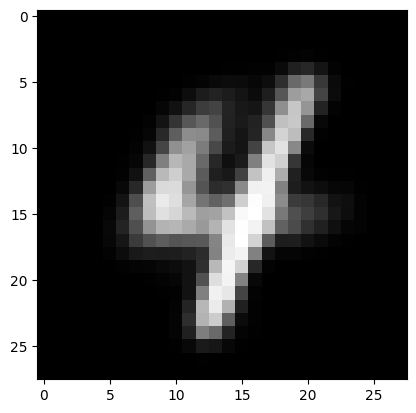

In [23]:
if LATENT_SPACE_DIM == 2:
    z = torch.Tensor([np.random.random_sample(size = LATENT_SPACE_DIM)]).to(device)
    cond = torch.nn.functional.one_hot(torch.tensor([4]), 10).to(device)
    pred = model.decoder(z, cond)
    plt.imshow(np.transpose(pred[0].cpu().detach().numpy(), (1,2,0)), cmap=plt.cm.gray)

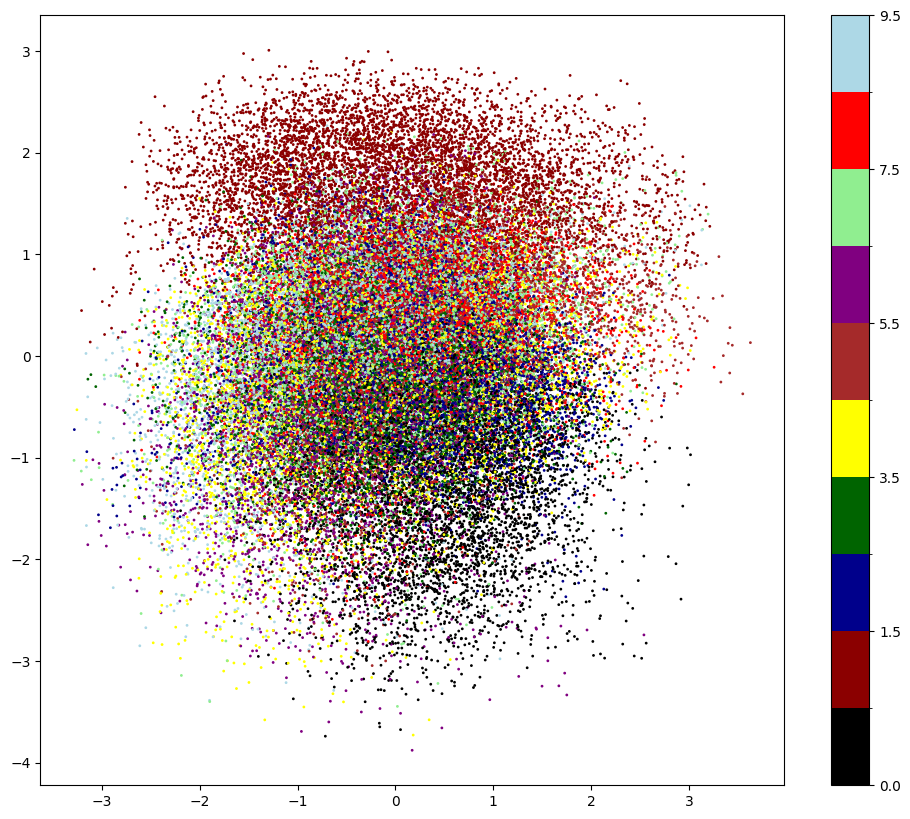

In [21]:
if LATENT_SPACE_DIM == 2:

    encoded_mean = []
    encoded_log_var = []
    targets = []
    for i,t in train_loader:
        mean, log_var = model.encoder(i.to(device))
        encoded_mean.extend(mean.cpu().detach().numpy())  
        encoded_log_var.extend(log_var.cpu().detach().numpy())
        targets.extend(t)

    x = [m[0] for m in encoded_mean]
    y = [m[1] for m in encoded_mean]

    plot_scatter(x,y,targets)

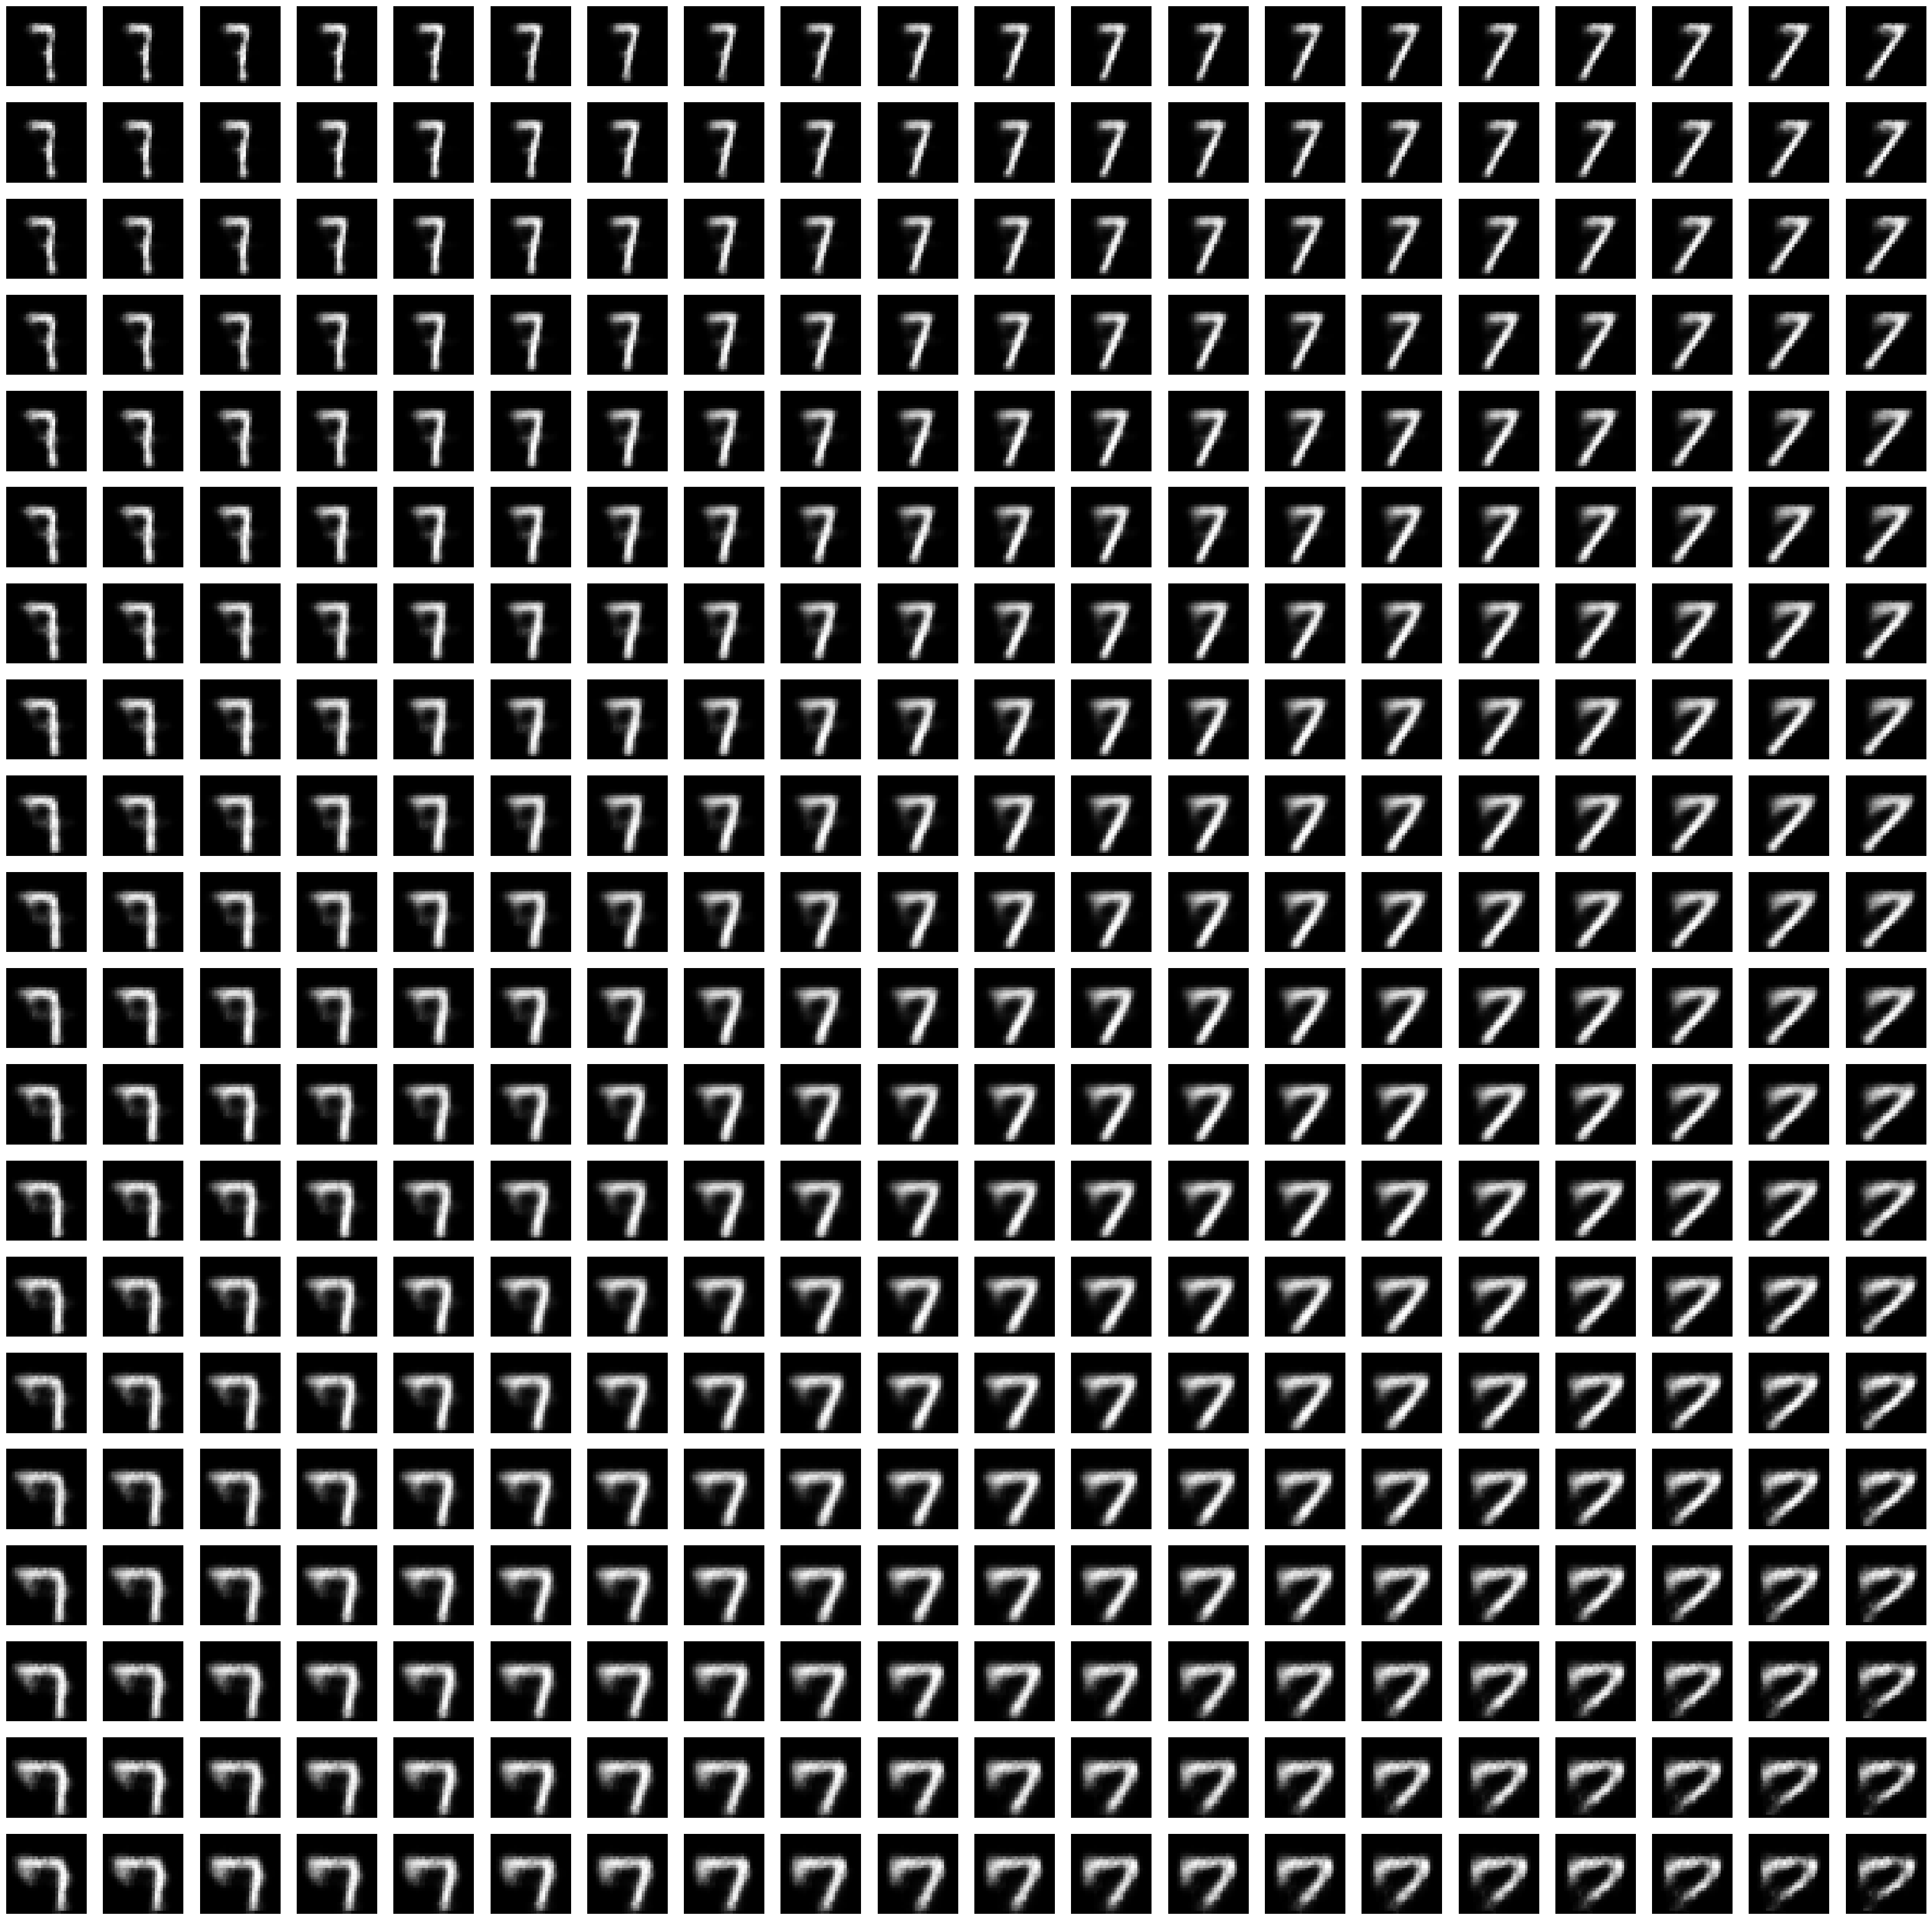

<Figure size 640x480 with 0 Axes>

In [25]:
if LATENT_SPACE_DIM == 2:
    limit = 2
    steps = 20

    step = (2.0 * limit) / steps

    vector_generation = [[-limit + j*step, limit - i*step] 
                                for i in range(steps) for j in range(steps)]

    number_class = 7
    t = [number_class for i in range(steps*steps)]

    z = torch.Tensor(vector_generation).to(device)
    y = torch.nn.functional.one_hot(torch.tensor(t), 10).to(device)
    predictions = model.decoder(z,y )

    vcpi_util.show_predicted_images(steps, steps, predictions.cpu().detach(), 10)